# Dataset

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import wget
import os
import tarfile

from torchvision.datasets import ImageFolder
from torch import tensor
from torchvision import transforms
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

IMAGENET_MEAN = tensor([.485, .456, .406])
IMAGENET_STD = tensor([.229, .224, .225])

DATA_PATH = "/content/mvtec_anomaly_detection"

POSSIBLE_CLASSES = [
    "bottle",
    "cable",
    "capsule",
    "carpet",
    "grid",
    "hazelnut",
    "leather",
    "metal_nut",
    "pill",
    "screw",
    "tile",
    "toothbrush",
    "transistor",
    "wood",
    "zipper",
]
def _convert_image_to_rgb(image):
    return image.convert("RGB")

class MVTecData(ImageFolder):

  def __init__(self, product, transform, target_transform):
    self.product = product
    if product in POSSIBLE_CLASSES:
      url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
      if not os.path.isdir(f'{DATA_PATH}'):
        if not os.path.exists(f'{DATA_PATH}.tar.xz'):
          print('Downloading dataset...')
          wget.download(url)
        print('Extracting dataset...')
        with tarfile.open(DATA_PATH+".tar.xz") as tar:
          tar.extractall(DATA_PATH)
      self.train_dataset = MVTecTrain(product, transform )
      self.test_dataset = MVTecTest(product, transform, target_transform)
    else:
      print(f'{product} not present in MVTEC Dataset')

  def get_datasets(self):
    return self.train_dataset, self.test_dataset

class MVTecTrain(ImageFolder):
  def __init__(self, product, transform):
    super().__init__(
        root = f'{DATA_PATH}/{product}/train/',
        transform = transform
    )
    self.product = product

class MVTecTest(ImageFolder):
  def __init__(self, product, transform, target_transform):
    super().__init__(
        root = f'{DATA_PATH}/{product}/test/',
        transform = transform,
        target_transform = target_transform,
    )
    self.product = product

  def __getitem__(self, index):
    path, _ = self.samples[index]
    sample = self.loader(path)
    if "good" in path:
      mask = Image.new("L", (256,256))
      sample_class = 0
    else:
      mask_path = path.replace("test", "ground_truth")
      mask_path = mask_path.replace(".png", "_mask.png")
      mask = self.loader(mask_path)
      sample_class = 1
    if self.transform is not None:
      sample = self.transform(sample)
    if self.target_transform is not None:
      mask = self.target_transform(mask)
    return sample, sample_class, mask

# PatchCore Model

In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bwljoewv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bwljoewv
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [4]:
import torch
import torch.nn.functional as F
import time
import numpy as np
import clip
from tqdm import tqdm
from sklearn import random_projection
from sklearn.metrics import roc_curve, auc, roc_auc_score
from torch import tensor, Tensor
from typing import Tuple, List
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [5]:
class PatchCore(torch.nn.Module):
  def __init__(self, backbone: 'resnet50', out_indices: Tuple = (2,3),
               input_size: int = 224, patch_size: int = 3, stride: int = 1,
               k: int = 3, sigma: int = 4, perc_coreset: float = 0.25, eps: float =0.9):
    super().__init__()
    self.out_indices = out_indices
    self.input_size = input_size
    self.k = k                                                                          # HYPERPARAMETER
    self.sigma = sigma
    self.kernel_size = int(2 * self.sigma * 4 + 1)
    if torch.cuda.is_available():
        self.device = 'cuda'
        self.to(self.device)
    else:
        self.device = 'cpu'
    self.feature_extractor, self.transformation = clip.load(backbone, device = self.device)
    self.target_transformation = target_transform = transforms.Compose([
          Resize(size=224, interpolation=InterpolationMode.BICUBIC),
          CenterCrop(size=(224, 224)),
          _convert_image_to_rgb ,
          ToTensor()  ])
    for param in self.feature_extractor.parameters():
      param.requires_grad = False
    self.feature_extractor.eval()                                                       # Inference mode instead of training
    self.pooling = torch.nn.AvgPool2d(patch_size, stride)                               # Pooling done after the feature extraction
    self.memory_bank = []
    self.perc_coreset = perc_coreset                                                    # HYPERPARAMETER
    self.eps = eps                                                                      # HYPERPARAMETER

  def get_transform(self):
    return self.transformation, self.target_transformation

  def forward(self, input: tensor):
    input = input.to(self.device)
    feature_maps = []
    def custom_hook(module, input, output):
      feature_maps.append(output)
    with torch.no_grad():
      self.feature_extractor.visual.layer2[-1].register_forward_hook(custom_hook)
      self.feature_extractor.visual.layer3[-1].register_forward_hook(custom_hook)
      self.feature_extractor.encode_image(input)
    return feature_maps

  def fit(self, input: DataLoader):
    patches = []
    for sample, _ in tqdm(input):
      feature_maps = self(sample)
      resized_features, _ = self.patch_extraction(feature_maps)
      patches.append(resized_features)
    patches = torch.cat(patches, dim=0)
    try:                                                                                # Applying JL Theorem
      transformation = random_projection.SparseRandomProjection(eps=self.eps)
      if self.device == 'cuda':
        patches = patches.to("cpu")
      reduced_patches = torch.tensor(transformation.fit_transform(patches))
      if self.device == 'cuda':
        reduced_patches = reduced_patches.to(self.device)
        patches = patches.to(self.device)
    except ValueError:
      print(f'Error in SparseRandomProjection')
    self.memory_bank = patches[self.coreset_reduction(reduced_patches)]

  def predict(self, sample):
    feature_maps = self(sample)
    resized_features, feature_map_size = self.patch_extraction(feature_maps)
    min_distances, nearest_neighbor_indexes = self.nearest_neighbour_search(resized_features, 1)    # Nearest Neighbour Search
    min_distances = min_distances.squeeze()
    nearest_neighbor_indexes = nearest_neighbor_indexes.squeeze()
    max_index = torch.argmax(min_distances)
    m_test = resized_features[max_index].unsqueeze(0)                                                   # Test features
    m_star = self.memory_bank[nearest_neighbor_indexes[max_index]].unsqueeze(0)                         # Memory bank features
    s_star = torch.cdist(m_test.float(), m_star.float())
    _, nb_indexes = self.nearest_neighbour_search(m_star, self.k)
    nb_features = self.memory_bank[nb_indexes]
    nb_distances = torch.cdist(m_test.float(), nb_features.float())
    w = 1 - (torch.exp(s_star)/torch.sum(torch.exp(nb_distances)))
    anomaly_score = w * s_star
    segmentation_map = min_distances.reshape(1, 1, *feature_map_size)
    segmentation_map = F.interpolate(segmentation_map, size=(self.input_size, self.input_size), mode='bilinear')
    segmentation_map = transforms.functional.gaussian_blur(segmentation_map, self.kernel_size, sigma = self.sigma)

    return anomaly_score, segmentation_map

  def evaluate(self, input: DataLoader):
    anomaly_scores = []
    segmentation_maps_flattened = []
    labels = []
    masks = []
    inference_times = []
    for sample, label, mask in tqdm(input):
      start_time = time.time()
      anomaly_score, segmentation_map = self.predict(sample)
      end_time = time.time()
      inference_times.append(end_time - start_time)
      segmentation_map = segmentation_map.to("cpu")
      anomaly_scores.append(anomaly_score.item())
      labels.append(label.item())
      segmentation_maps_flattened.extend(segmentation_map.flatten().numpy())
      mask = torch.mean(mask, dim=1, keepdim=True)
      masks.extend(mask.flatten().numpy().astype(int))

    fpr_sm, tpr_sm, thresholds = roc_curve(masks, segmentation_maps_flattened)    # Roc curve for segmentation map
    roc_auc_sm = auc(fpr_sm, tpr_sm)

    y_true = np.array(labels)
    y_scores = np.array(anomaly_scores)
    fpr_as, tpr_as, thresholds = roc_curve(y_true, y_scores)                      #Roc curve for anomaly score
    roc_auc_as = auc(fpr_as, tpr_as)

    return fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, sum(inference_times)/len(inference_times)


  def resize(self, input_features: List[Tensor], new_size) -> Tensor:
    resized_features = []
    for input_feature in input_features:
      resized_features.append(F.adaptive_avg_pool2d(input_feature, new_size))
    resized_features = torch.cat(resized_features, dim=1)
    return resized_features

  def reshape(self, input_features: Tensor) -> Tensor:
    num_features = input_features.size(1)
    input_features = input_features.permute(0,2,3,1).reshape(-1, num_features)
    return input_features

  def coreset_reduction(self, patches: List[Tensor]) -> List[Tensor]:
    coreset_indexes = []
    index = 0
    last_item = patches[index : index + 1]
    coreset_indexes.append(index)
    min_distances = torch.linalg.norm(patches - last_item, dim=1, keepdims=True)
    while len(coreset_indexes) <= int(len(patches) * self.perc_coreset):
      distances = torch.linalg.norm(patches - last_item, dim=1, keepdims=True)
      min_distances = torch.minimum(distances, min_distances)
      index = torch.argmax(min_distances)
      last_item = patches[index : index + 1]
      min_distances[index] = 0
      coreset_indexes.append(index)
    return coreset_indexes

  def nearest_neighbour_search(self, sample_features, k=1):
    distances = torch.cdist(sample_features, self.memory_bank)
    scores, nearest_neighbor_indexes = distances.topk(k, largest=False)
    return scores, nearest_neighbor_indexes

  # Questo dipende da cosa ci ritorna clip
  def patch_extraction(self, feature_maps):
    features = []
    for feature_map in feature_maps:
        features.append(self.pooling(feature_map))
    feature_map_size = feature_maps[0].shape[-2:]
    resized_features = self.resize(features, feature_map_size)                        # Custom methods to resize and reshape the patches
    resized_features = self.reshape(resized_features)
    return resized_features, feature_map_size


# Main

## PatchCore Improved

In [6]:
import matplotlib.pyplot as plt

In [7]:
def print_stats(fpr, tpr, roc_auc):
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Tasso di falso positivo (1 - Specificità)')
  plt.ylabel('Tasso di vero positivo (Sensibilità)')
  plt.title('Curva ROC')
  plt.legend(loc="lower right")
  plt.show()

Hyperparameters chosen:

* K = 3
* % Coreset Subsampling = 25%
* eps = 0.9
* Net = ResNet50

In [8]:
total_inference_times = []

-------------DATASET: BOTTLE-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|███████████████████████████████████████| 244M/244M [00:02<00:00, 97.1MiB/s]


Extracting dataset...


100%|██████████| 83/83 [00:08<00:00,  9.65it/s]


Segmentation map (Anomaly segmentation):


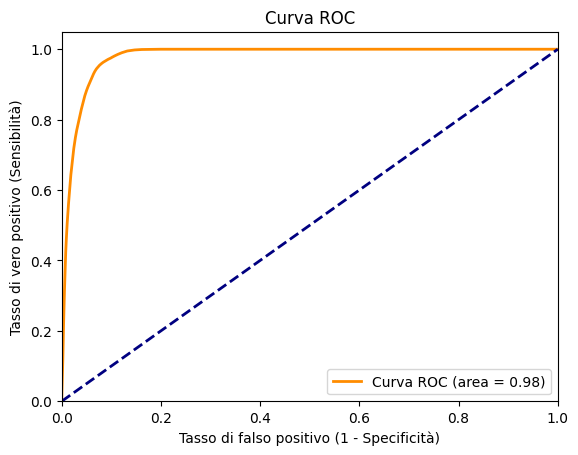

Anomaly score (Anomaly Detection): 


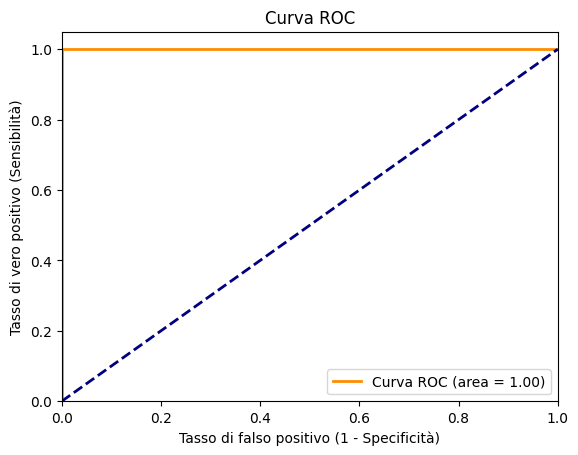

Inference Time: 0.03859867819820542


In [9]:
print('-------------DATASET: BOTTLE-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('bottle',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: CABLE-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 150/150 [00:19<00:00,  7.82it/s]


Segmentation map (Anomaly segmentation):


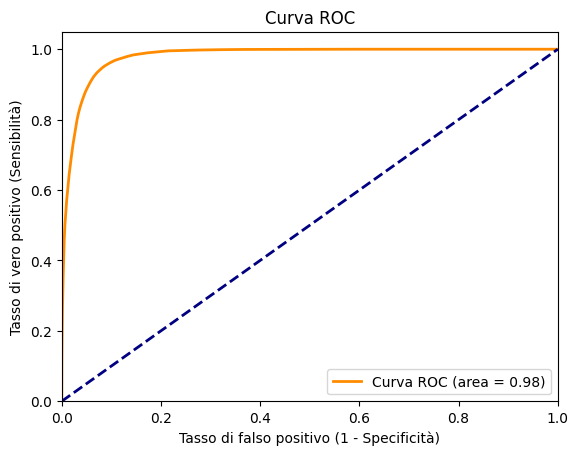

Anomaly score (Anomaly Detection): 


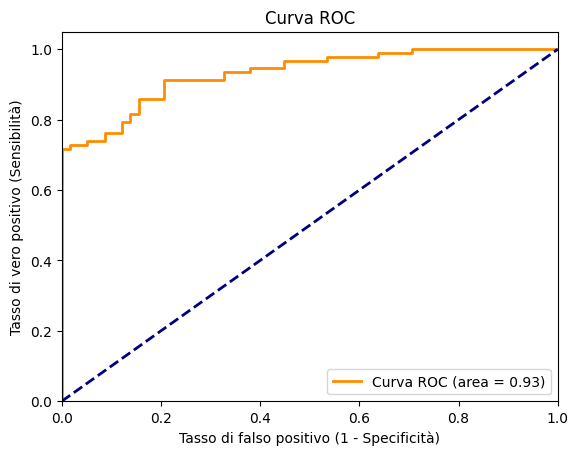

Inference Time: 0.041323134104410804


In [10]:
print('-------------DATASET: CABLE-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('cable',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: CAPSULE-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 132/132 [00:16<00:00,  7.96it/s]


Segmentation map (Anomaly segmentation):


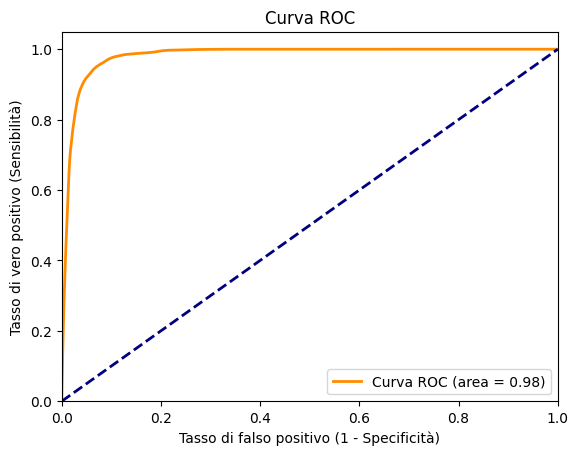

Anomaly score (Anomaly Detection): 


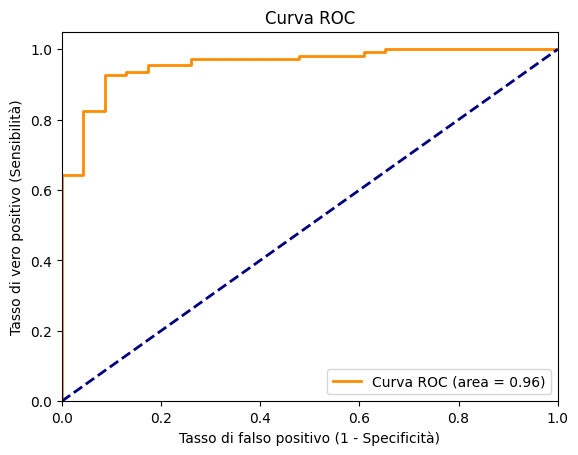

Inference Time: 0.03957091497652458


In [11]:
print('-------------DATASET: CAPSULE-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('capsule',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: CARPET-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 117/117 [00:15<00:00,  7.71it/s]


Segmentation map (Anomaly segmentation):


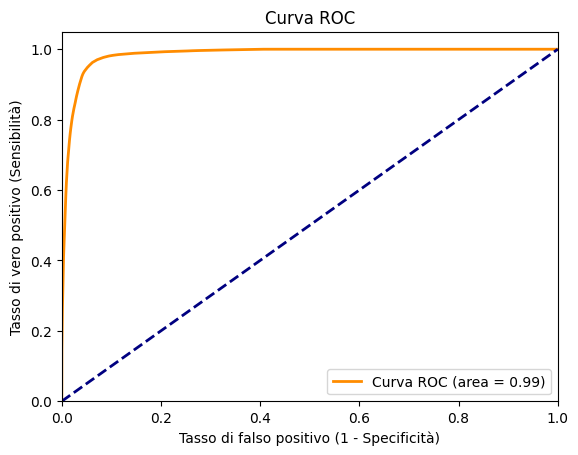

Anomaly score (Anomaly Detection): 


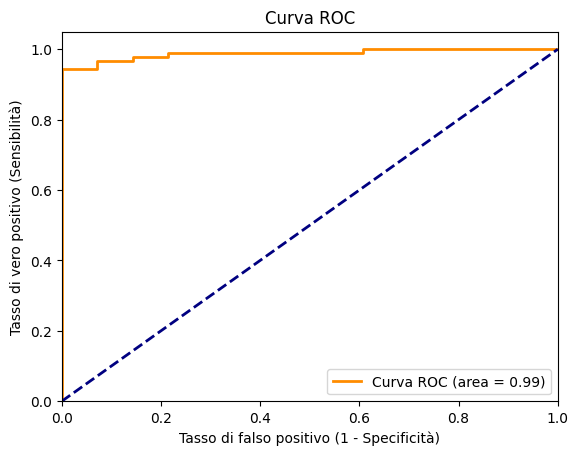

Inference Time: 0.0446780461531419


In [12]:
print('-------------DATASET: CARPET-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('carpet',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: GRID-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 78/78 [00:07<00:00, 10.87it/s]


Segmentation map (Anomaly segmentation):


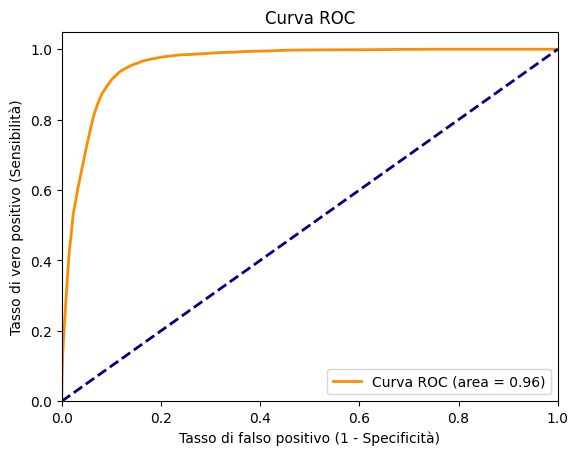

Anomaly score (Anomaly Detection): 


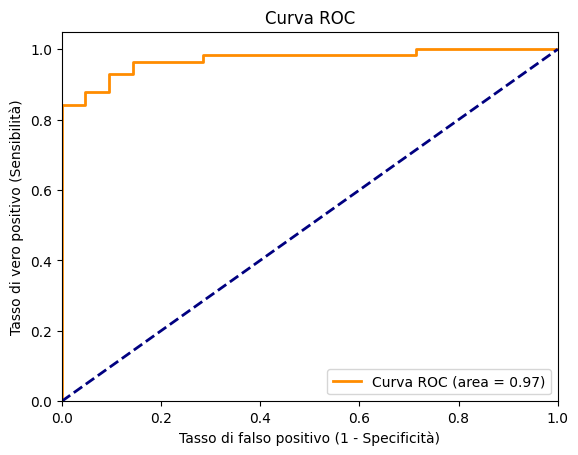

Inference Time: 0.03647530384552784


In [13]:
print('-------------DATASET: GRID-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('grid',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: HAZELNUT-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 110/110 [00:15<00:00,  7.29it/s]


Segmentation map (Anomaly segmentation):


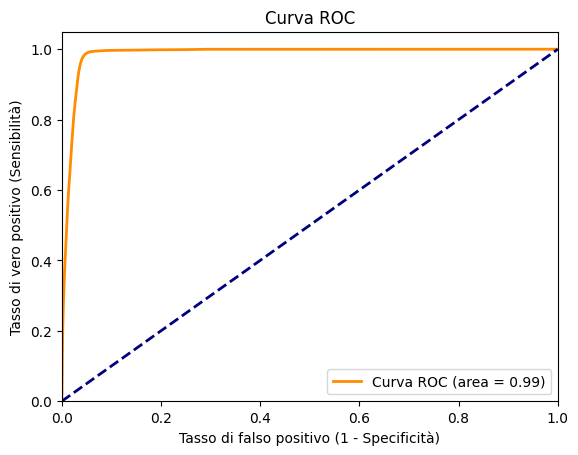

Anomaly score (Anomaly Detection): 


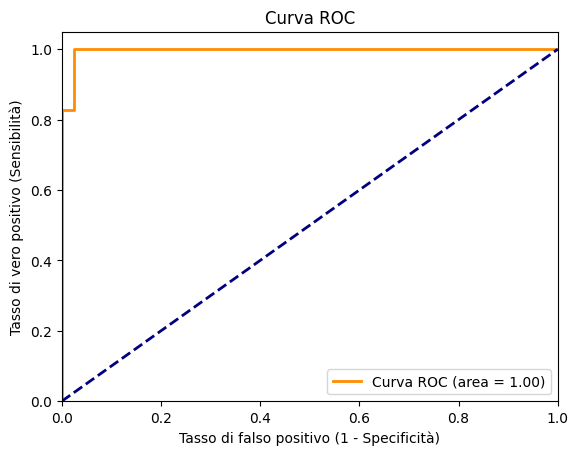

Inference Time: 0.054578395323319866


In [9]:
print('-------------DATASET: HAZELNUT-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('hazelnut',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: LEATHER-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 124/124 [00:14<00:00,  8.45it/s]


Segmentation map (Anomaly segmentation):


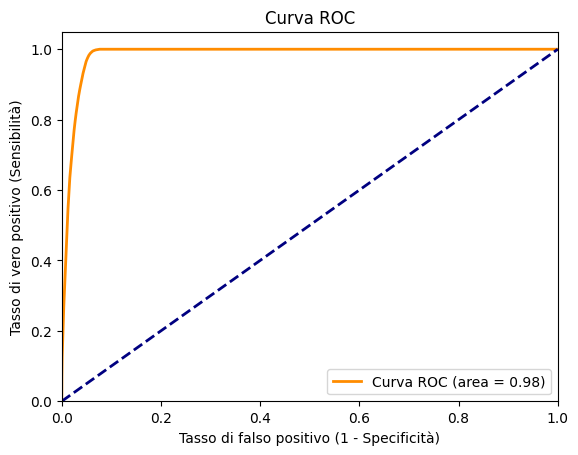

Anomaly score (Anomaly Detection): 


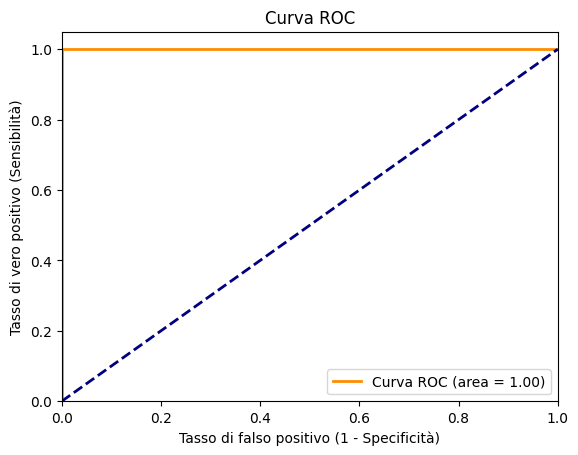

Inference Time: 0.04185181087063205


In [10]:
print('-------------DATASET: LEATHER-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('leather',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: METAL NUT-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 115/115 [00:09<00:00, 12.45it/s]


Segmentation map (Anomaly segmentation):


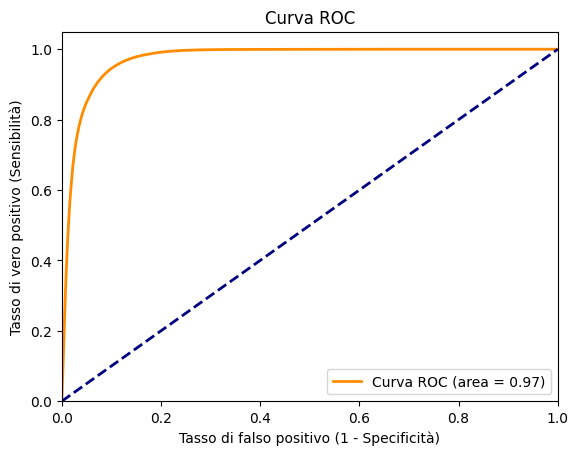

Anomaly score (Anomaly Detection): 


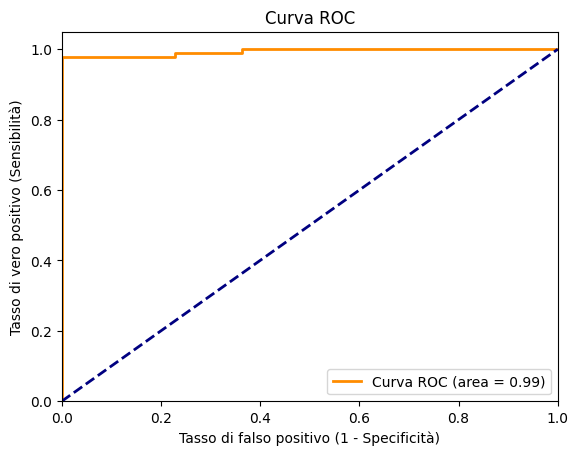

Inference Time: 0.03283372547315515


In [11]:
print('-------------DATASET: METAL NUT-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('metal_nut',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: PILL-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 167/167 [00:15<00:00, 10.81it/s]


Segmentation map (Anomaly segmentation):


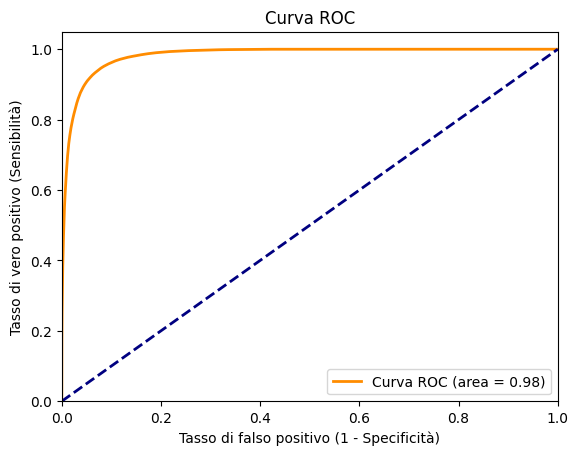

Anomaly score (Anomaly Detection): 


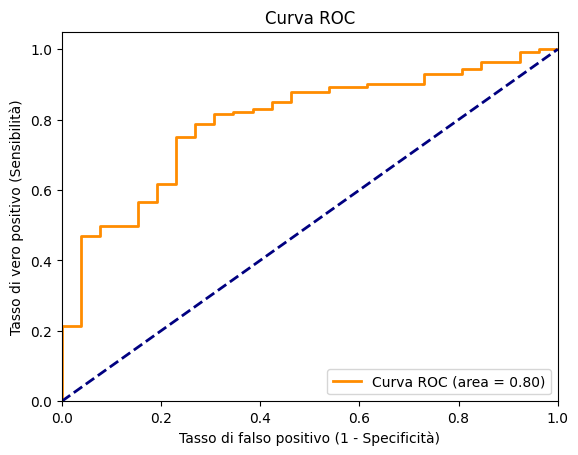

Inference Time: 0.03686485033549235


In [12]:
print('-------------DATASET: PILL-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('pill',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: SCREW-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 160/160 [00:15<00:00, 10.58it/s]


Segmentation map (Anomaly segmentation):


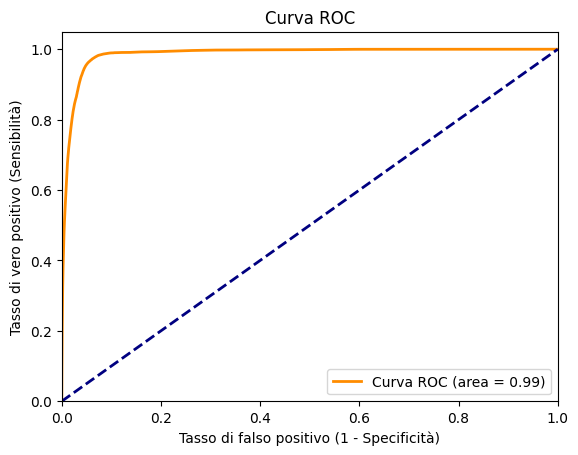

Anomaly score (Anomaly Detection): 


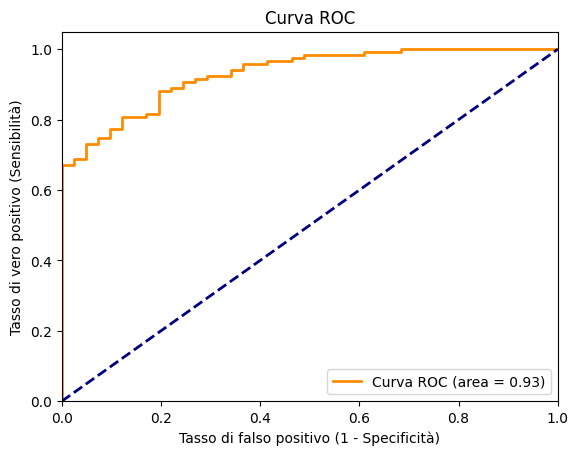

Inference Time: 0.03998175263404846


In [13]:
print('-------------DATASET: SCREW-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('screw',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: TILE-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 117/117 [00:11<00:00, 10.26it/s]


Segmentation map (Anomaly segmentation):


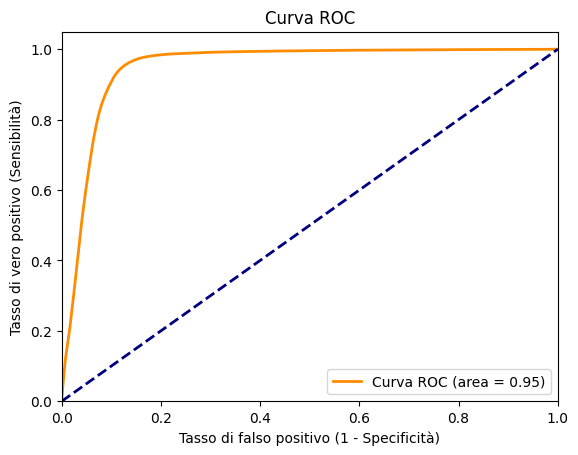

Anomaly score (Anomaly Detection): 


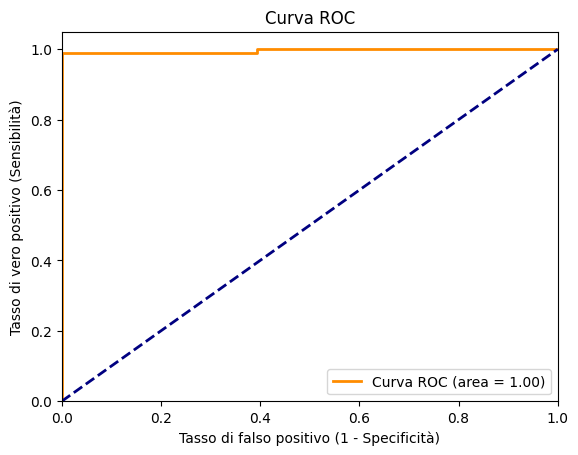

Inference Time: 0.036281045685466536


In [14]:
print('-------------DATASET: TILE-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('tile',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: TOOTHBRUSH-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 42/42 [00:03<00:00, 11.04it/s]


Segmentation map (Anomaly segmentation):


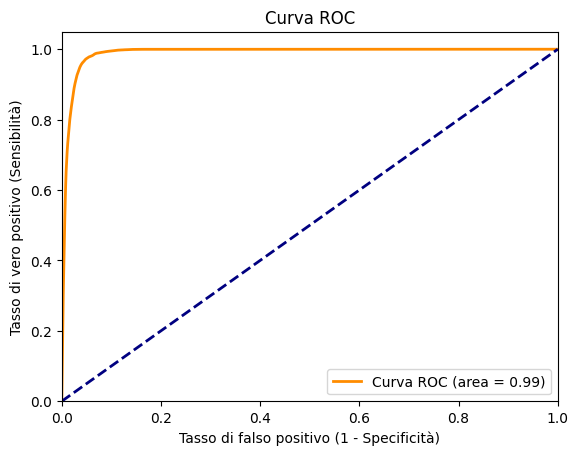

Anomaly score (Anomaly Detection): 


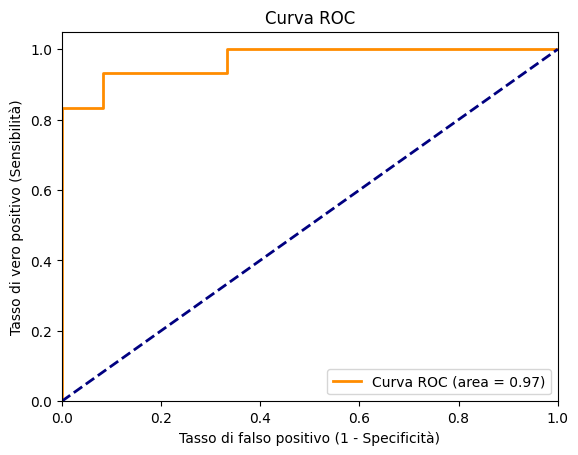

Inference Time: 0.01691892601194836


In [15]:
print('-------------DATASET: TOOTHBRUSH-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('toothbrush',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: TRANSISTOR-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Segmentation map (Anomaly segmentation):


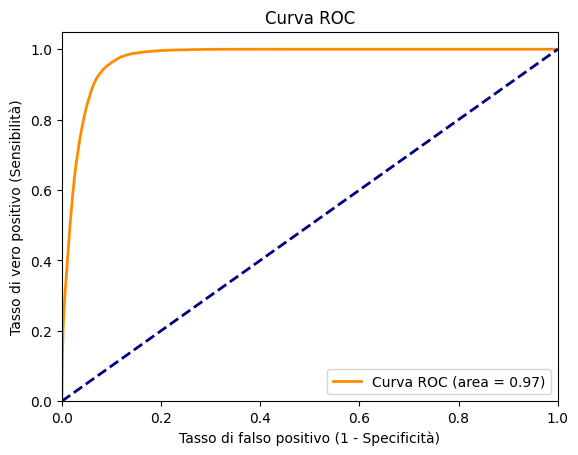

Anomaly score (Anomaly Detection): 


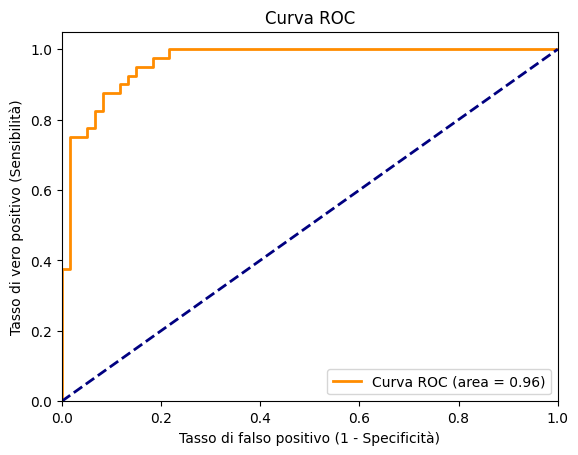

Inference Time: 0.038328123092651364


In [16]:
print('-------------DATASET: TRANSISTOR-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('transistor',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: WOOD-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 79/79 [00:09<00:00,  7.91it/s]


Segmentation map (Anomaly segmentation):


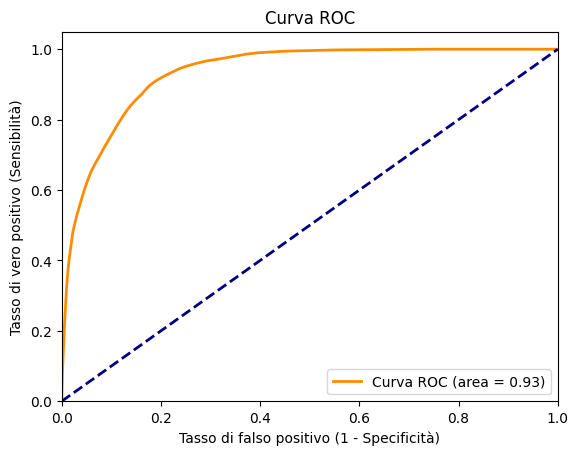

Anomaly score (Anomaly Detection): 


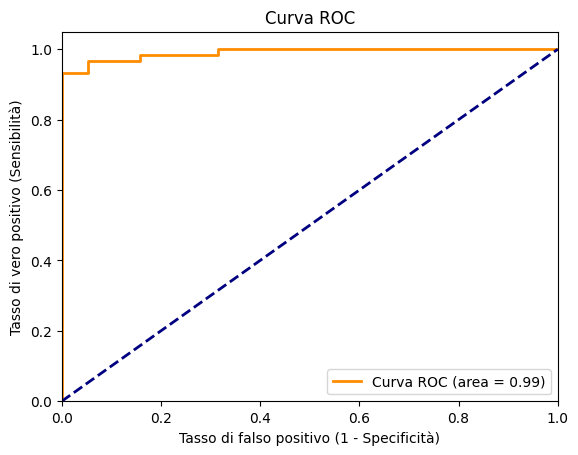

Inference Time: 0.04175932196122181


In [17]:
print('-------------DATASET: WOOD-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('wood',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

-------------DATASET: ZIPPER-------------
-------------MODEL: PATCHCORE IMPROVED-------------


100%|██████████| 151/151 [00:12<00:00, 11.73it/s]


Segmentation map (Anomaly segmentation):


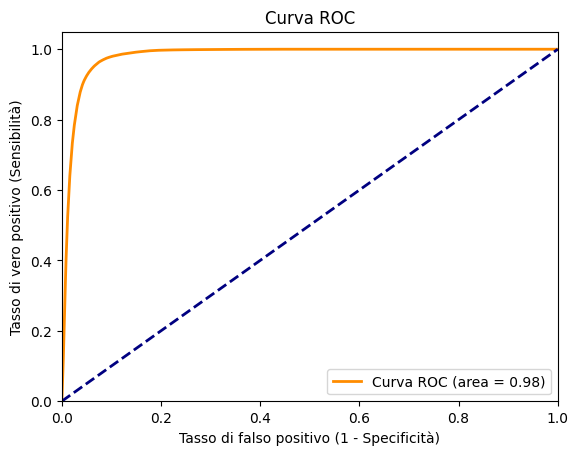

Anomaly score (Anomaly Detection): 


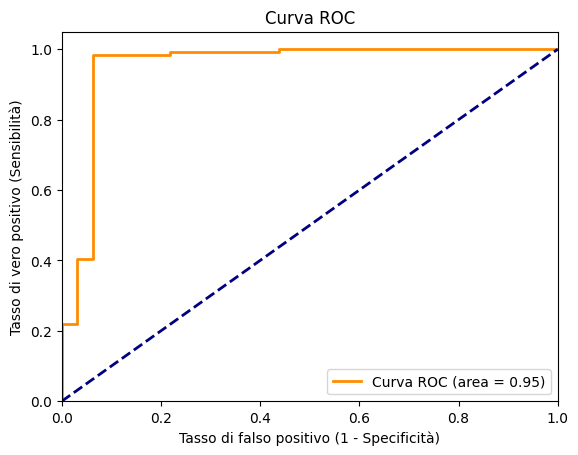

Inference Time: 0.034471467630752664


In [18]:
print('-------------DATASET: ZIPPER-------------')
print('-------------MODEL: PATCHCORE IMPROVED-------------')
model = PatchCore('RN50')
transform, target_transform = model.get_transform()
train_data, test_data = MVTecData('zipper',transform, target_transform).get_datasets()
train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=False)
model.fit(train_dataloader)
fpr_sm, tpr_sm, fpr_as, tpr_as, roc_auc_as, roc_auc_sm, inference_time = model.evaluate(test_dataloader)
print('Segmentation map (Anomaly segmentation):')
print_stats(fpr_sm, tpr_sm, roc_auc_sm)
print('Anomaly score (Anomaly Detection): ')
print_stats(fpr_as, tpr_as, roc_auc_as)
print(f'Inference Time: {inference_time}')
total_inference_times.append(inference_time)

In [19]:
print(f'Inference time mean: {sum(total_inference_times) / len(total_inference_times)}')

Inference time mean: 0.03738694190186886


## TODO: Fare altri lanci cambiando gli iperparametri